In [3]:
pip install tweepy

  Using cached tweepy-3.10.0-py2.py3-none-any.whl (30 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)



In [2]:
import os
import tweepy as tw
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import datetime as dt
import tweepy as tw
import nltk
from nltk.corpus import stopwords
import re
import networkx
from textblob import TextBlob


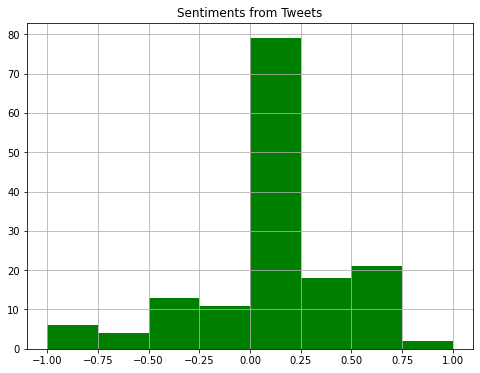

Sum of scores in positive sentiment: 27.558570075757572
Sum of scores in negative sentiment: 15.229166666666668


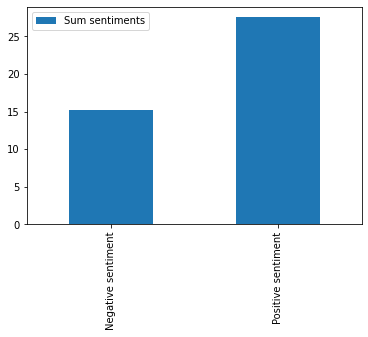

In [50]:
ruta=r'\Users\Alberto\Documents\Big Data\pirple\twitter'
consumer_key= 'yQ4xnp7UG64FkmSc88zQRB4Kk'
consumer_secret= 'fSxHYYL3PjiNhAsn0IhLgQNogC5N2qOWBtGokDAlEWrJFi6CuZ'
access_token= '1139599692684300288-CjLtSZxQVYoWa86PQlpHvYBuHs1hqn'
access_token_secret= 'eqA6quZ27JEMOaFeDOCfVjqzSQjpR9RvOWV6QRvP8GuZR'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return re.sub(r"https:(\/\/t\.co\/([A-Za-z0-9]|[A-Za-z]){10})", "", txt)


def twittersearch(keywords,date,name_csv,numberofdoc):
#our credentials to access the Developer API of Twitter
  
    search_words=f"{keywords}"
    search_words_noRT =f"{keywords}+-filter:retweets"

    date_since = f"{date}"


#for NO_RT query
    tweets_noRT = tw.Cursor(api.search,
              q=search_words_noRT,
              lang="es",
              since=date_since).items(numberofdoc)
    
    user_query_noRT=[
        [tweet.created_at,
        tweet.user.screen_name,
        tweet.user.location,
        tweet.user.followers_count,
        tweet.text,
        tweet.source]

        for tweet in tweets_noRT
    ]

    tweets_noRT=[remove_url(tweet.text) for tweet in tweets_noRT]

#creating the pandas DF with no RT. 
    tweets_df_noRT = pd.DataFrame(data=user_query_noRT, 
                    columns=['Fecha','user',"location","followers","text","source"])

# dropping ALL duplicte values 
    tweets_df_noRT.drop_duplicates(subset ="user", 
                     keep = False, inplace = True) 

    global ruta
    return tweets_df_noRT.to_csv(os.path.join(ruta,f'{name_csv}.csv'))


def sentiment(name_csv):
    global ruta
    ruta=os.path.join(ruta,f'{name_csv}.csv')
    df=pd.read_csv(ruta)

    df['fecha']=pd.to_datetime(df['Fecha'])
    df['año']=df['fecha'].dt.year
    df['mes']=df['fecha'].dt.month
    df['dia']=df['fecha'].dt.day
    df['time']=df['fecha'].dt.time
    df['hour']=df['fecha'].dt.hour
    df['min']=df['fecha'].dt.minute

    df=df.fillna(0)
    df=df.drop(columns=['Fecha','fecha','Unnamed: 0'])

    
# Create textblob objects of the tweets
    sentiment_objects = [TextBlob(tweet) for tweet in df['text']]

    sentiment_objects[0].polarity, sentiment_objects[0]

    sentiment_values=[[tweet.sentiment.polarity,str(tweet)] for tweet in sentiment_objects]

# Create dataframe containing the polarity value and tweet text
    sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity","tweet"])

    sentiment_df=sentiment_df[sentiment_df.polarity!=0]
    sentiment_df_positive=sentiment_df[sentiment_df.polarity>0]
    sentiment_df_negative=sentiment_df[sentiment_df.polarity<0]

#plot the results in a histogram
    fig, ax = plt.subplots(figsize=(8, 6))

    sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="green")

    plt.title("Sentiments from Tweets")
    plt.show()

#plotting the overall sentiment
    sumneg=sentiment_df_negative.polarity.sum()
    sumpos=sentiment_df_positive.polarity.sum()
    df_sum=pd.DataFrame(index=['Negative sentiment','Positive sentiment'],data=[abs(sumneg),sumpos],columns=['Sum sentiments'])
    df_sum.plot.bar()
    print('Sum of scores in positive sentiment:',sumpos)
    print('Sum of scores in negative sentiment:',abs(sumneg))

def twittersentiment(keyword,datesince,name_csv,num_of_doc): 
    twittersearch(f'{keyword}',f'{datesince}',f'{name_csv}',num_of_doc)
    sentiment(f'{name_csv}')

twittersentiment('COVID-19','2021-01-16','p2',10000)
